In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

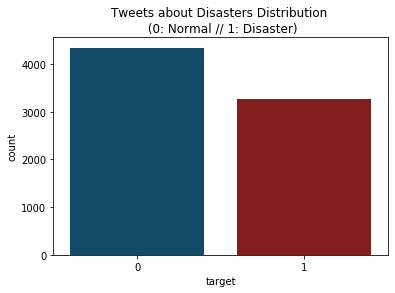

<Figure size 432x288 with 0 Axes>

In [3]:
# looking at distribution of targets

colors = ['#054e79', '#940b0b']
sns.countplot('target', data=train, palette=colors)
plt.title('Tweets about Disasters Distribution \n (0: Normal // 1: Disaster)')
plt.figure()
plt.show()
# ~ 40/60 disaster-to-normal split

In [4]:
train_df, val_df = train_test_split(train, test_size=0.2, random_state=1)

In [5]:
# tokenize and update vocabulary based on training text

tk = Tokenizer()
train_text = train_df['text'].to_numpy()
tk.fit_on_texts(train_text)
vocab_size = len(tk.word_index) + 1
print(vocab_size)

19424


In [6]:
# after tokenizing text, want to convert into sequences (i.e. mapping text to a seq of integers)

def text_to_seq(text):
    seq = tk.texts_to_sequences(text)
    seq = tf.keras.preprocessing.sequence.pad_sequences(seq, padding='post')
    return seq

train_seq = text_to_seq(train_text)
train_target = train_df['target'].to_numpy()

val_text = val_df['text'].to_numpy()
val_seq = text_to_seq(val_text)
val_target = val_df['target'].to_numpy()

test_text = test['text'].to_numpy()
test_seq = text_to_seq(test_text)

train_ds = tf.data.Dataset.from_tensor_slices((train_seq, train_target))
val_ds = tf.data.Dataset.from_tensor_slices((val_seq, val_target))

In [7]:
BUFFER_SIZE = 6090
BATCH_SIZE = 32

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

In [8]:
# prefetching is used to decouple the time between when data is produced and consumed

train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [9]:
# build a sequential model for RNN
model = tf.keras.Sequential([
    layers.Embedding(vocab_size, 32),
    layers.Bidirectional(tf.keras.layers.LSTM(32)),
    layers.Dropout(0.4),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[callback])

Epoch 1/50
191/191 [==============================] - 7s 37ms/step - loss: 0.6908 - accuracy: 0.5379 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
191/191 [==============================] - 2s 10ms/step - loss: 0.6795 - accuracy: 0.5681 - val_loss: 0.6640 - val_accuracy: 0.5791
Epoch 3/50
191/191 [==============================] - 2s 11ms/step - loss: 0.6435 - accuracy: 0.6090 - val_loss: 0.6095 - val_accuracy: 0.6612
Epoch 4/50
191/191 [==============================] - 2s 11ms/step - loss: 0.5582 - accuracy: 0.7550 - val_loss: 0.5148 - val_accuracy: 0.7722
Epoch 5/50
191/191 [==============================] - 2s 11ms/step - loss: 0.4272 - accuracy: 0.8278 - val_loss: 0.4652 - val_accuracy: 0.7965
Epoch 6/50
191/191 [==============================] - 2s 11ms/step - loss: 0.3467 - accuracy: 0.8701 - val_loss: 0.4574 - val_accuracy: 0.7958
Epoch 7/50
191/191 [==============================] - 2s 11ms/step - loss: 0.2622 - accuracy: 0.9034 - val_loss: 0.4730 - val_accuracy

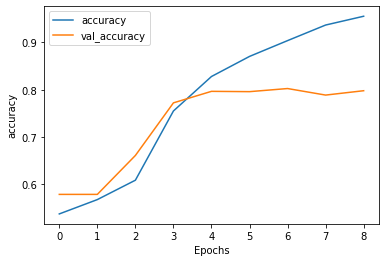

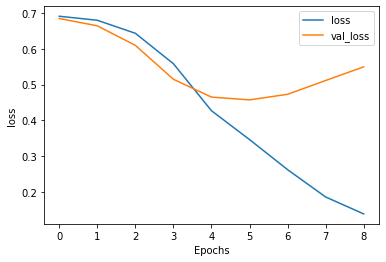

In [11]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [12]:
test['target'] = model.predict(test_seq)

# again, since binary classification, >0.5 indicates disaster, <0.5 indicates non-disaster

In [13]:
test.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0.995025
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0.980942
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0.995831
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.830819
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0.998456


In [14]:
# w/ val_accuracy around 0.79, model also predicts disasters fairly well
# save this dataframe to csv to view all predictions

test.to_csv('tf_test_pred.csv')